<a href="https://colab.research.google.com/github/pinkdolphin11/ESAA/blob/main/Session_1205_KerasCNNdogcat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [10]:
import numpy as np
import pandas as pd 
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir('/content/drive/MyDrive/ESAAdata'))

['mercaridata', 'OpinosisDataset1.0', 'ratings_Electronics (1).csv', 'tmdb_5000_credits.csv', 'tmdb_5000_movies.csv', 'ml-latest-small', 'test_500', 'train_700']


# Define Constants

In [36]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Training Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
filenames = os.listdir("/content/drive/MyDrive/ESAAdata/train_700")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [15]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.101.jpg,0
2,cat.104.jpg,0
3,cat.102.jpg,0
4,cat.100.jpg,0


In [16]:
df.tail()

,filename,category
1397,dog.76.jpg,1
1398,dog.73.jpg,1
1399,dog.74.jpg,1
1400,dog.72.jpg,1
1401,dog.700.jpg,1


## See Total in Count

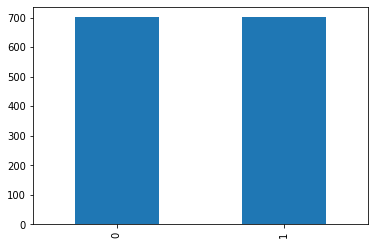

In [17]:
df['category'].value_counts().plot.bar()

## See sample image

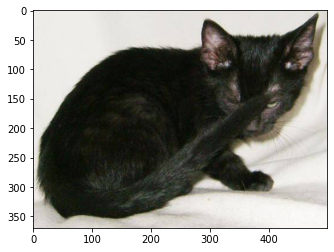

In [19]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/ESAAdata/train_700/"+sample)
plt.imshow(image)

# Build Model

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

# Callbacks

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Early Stop

In [22]:
earlystop = EarlyStopping(patience=10)

## Learning Rate Reduction

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [24]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare Data

In [25]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [26]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

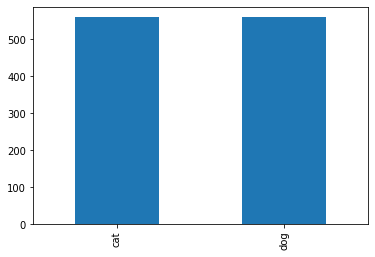

In [27]:
train_df['category'].value_counts().plot.bar()

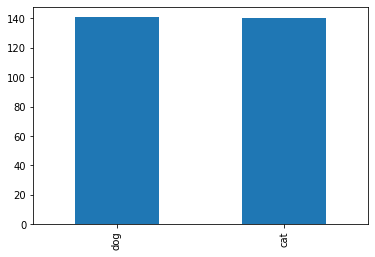

In [28]:
validate_df['category'].value_counts().plot.bar()

In [29]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Training Generator

In [30]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/ESAAdata/train_700", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1121 validated image filenames belonging to 2 classes.


## Validation Generator

In [31]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/ESAAdata/train_700", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 281 validated image filenames belonging to 2 classes.


## See how our generator work

In [32]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/MyDrive/ESAAdata/train_700", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


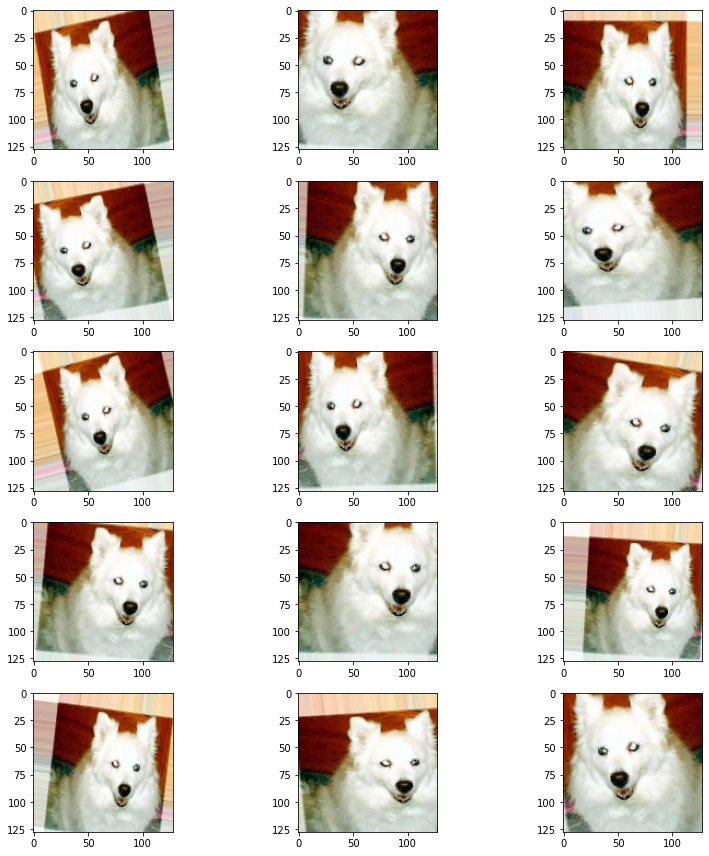

In [33]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [37]:
epochs = 3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3


<ipython-input-37-d03f11cc90e8>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


74/74 [==============================] - ETA: 0s - loss: 0.9884 - accuracy: 0.5769

74/74 [==============================] - 62s 839ms/step - loss: 0.9884 - accuracy: 0.5769 - val_loss: 0.9083 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/3
74/74 [==============================] - ETA: 0s - loss: 0.8777 - accuracy: 0.5922

74/74 [==============================] - 60s 807ms/step - loss: 0.8777 - accuracy: 0.5922 - val_loss: 2.1111 - val_accuracy: 0.5037 - lr: 0.0010
Epoch 3/3
74/74 [==============================] - ETA: 0s - loss: 0.8160 - accuracy: 0.6031

74/74 [==============================] - 60s 811ms/step - loss: 0.8160 - accuracy: 0.6031 - val_loss: 2.0331 - val_accuracy: 0.4963 - lr: 0.0010


# Save Model

In [38]:
model.save_weights("model.h5")

# Virtualize Training

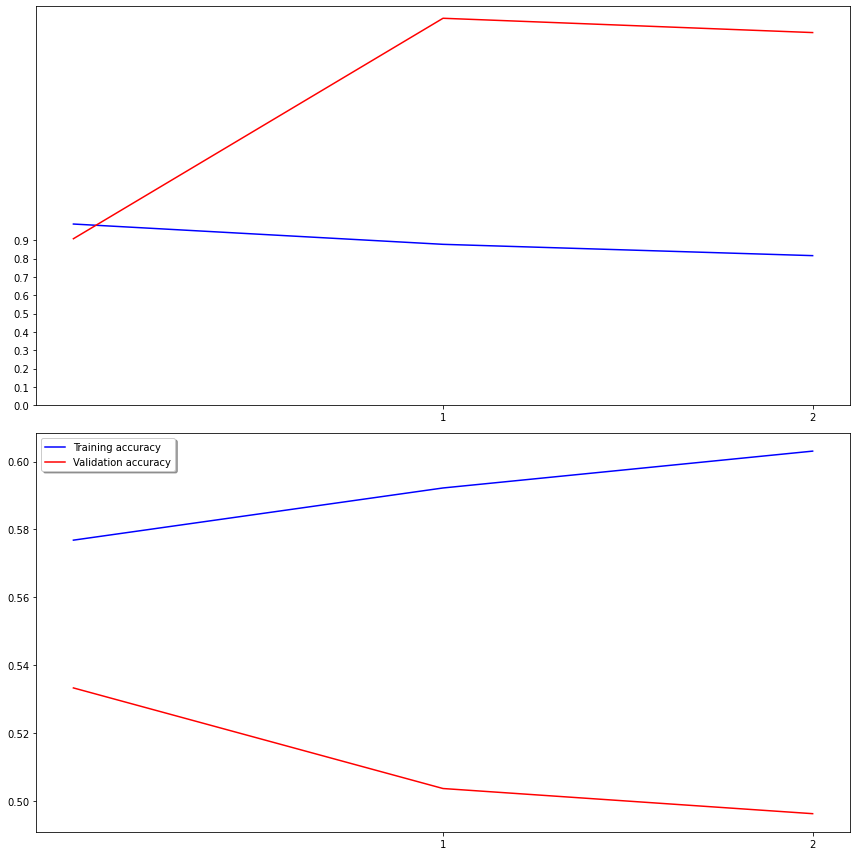

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [12]:
test_filenames = os.listdir("/content/drive/MyDrive/ESAAdata/test_500")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [41]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/ESAAdata/test_500", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


# Predict

In [42]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-42-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [43]:
test_df['category'] = np.argmax(predict, axis=-1)

In [44]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [45]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

## Virtualize Result

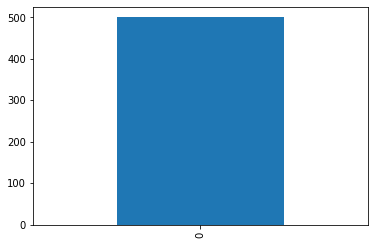

In [46]:
test_df['category'].value_counts().plot.bar()

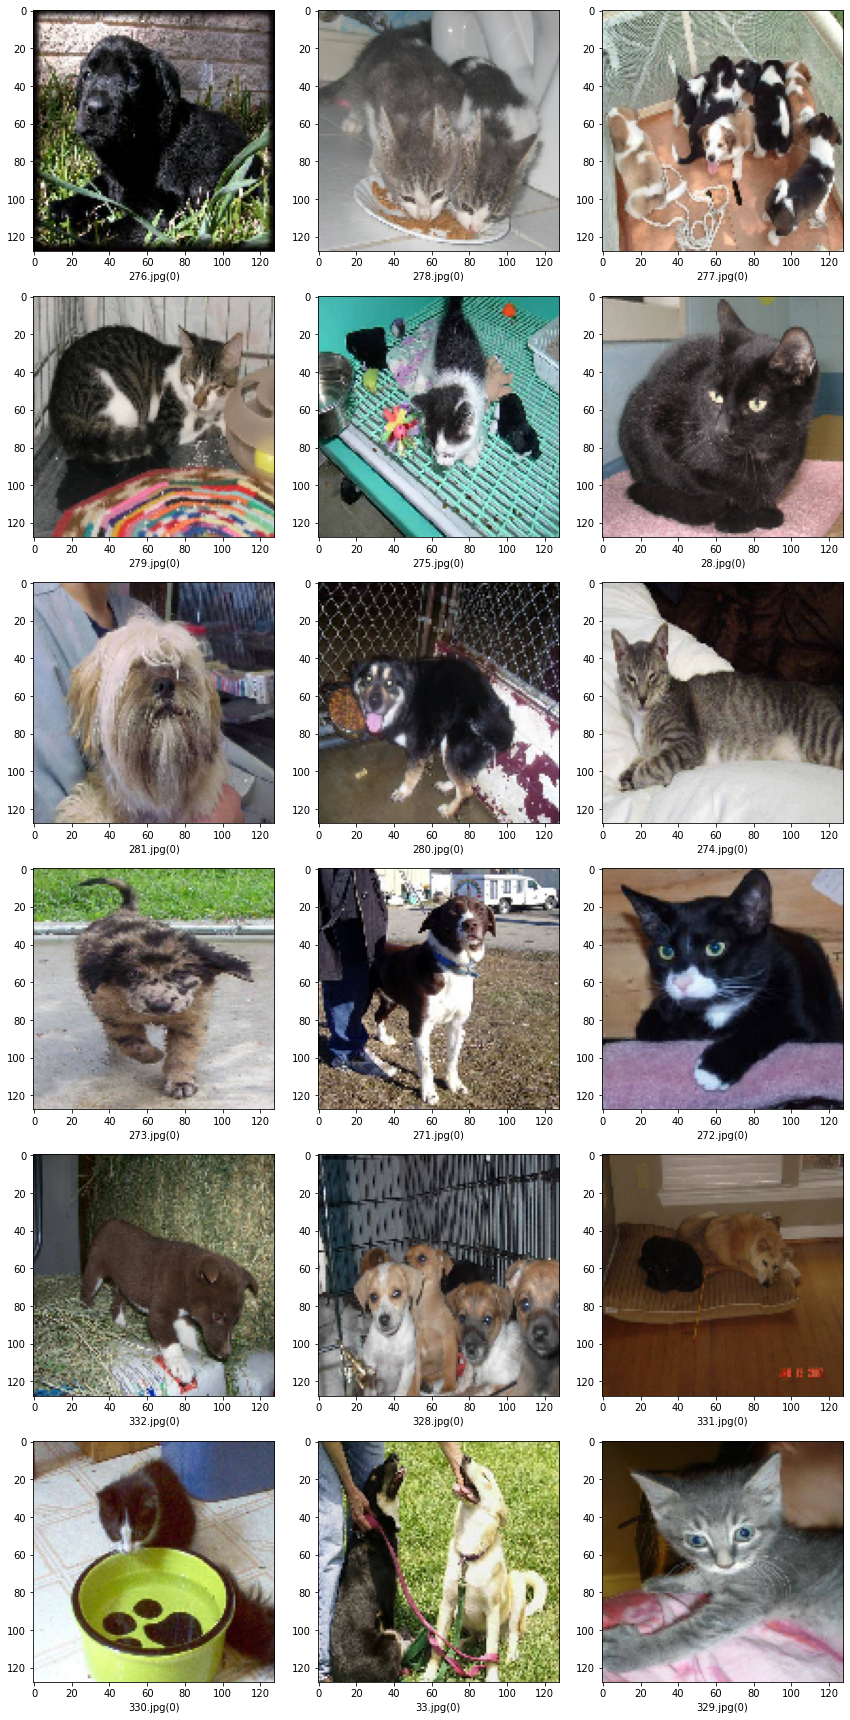

In [48]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/ESAAdata/test_500/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [49]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)